# Spotify Features

In [1]:
%pip install seaborn


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set_theme()
variables = ["danceability","energy","acousticness","instrumentalness","valence"]

In [3]:
# Load one of the datasets by track
data = pd.read_csv("/opt/app-root/src/music-recommendation/data/merged_1000_tag_probs_by_track.csv")
data[variables].describe()

,danceability,energy,acousticness,instrumentalness,valence
count,14008.000000,14008.000000,14008.000000,14008.000000,14008.000000
mean,0.599196,0.631336,0.220747,0.514391,0.435869
std,0.192551,0.233408,0.302225,0.382463,0.279360
min,0.055300,0.000264,0.000001,0.000000,0.000000
25%,0.495750,0.492000,0.005610,0.035275,0.185000
50%,0.637000,0.666000,0.055750,0.683000,0.417000
75%,0.743250,0.817000,0.339000,0.872000,0.662000
max,0.988000,1.000000,0.996000,0.999000,1.000000


# danceability
 Mean: 0.5991956667618504
 Std: 0.192550702142264
# energy
 Mean: 0.6313359660194174
 Std: 0.23340814353591122
# acousticness
 Mean: 0.2207465004854369
 Std: 0.3022249989840806
# instrumentalness
 Mean: 0.5143905239141919
 Std: 0.3824632244159995
# valence
 Mean: 0.43586859651627646
 Std: 0.2793598900597052


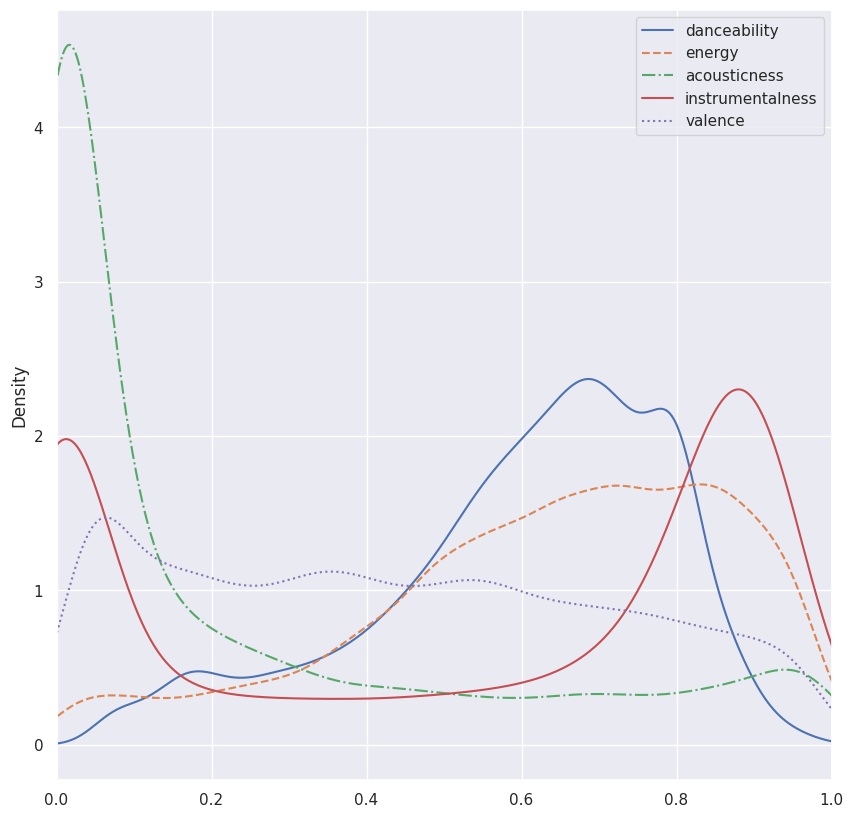

In [4]:

import matplotlib.pyplot as plt

lines = ["-","--", "dashdot", "-", ":"]

for v, linestyle in zip(variables, lines):
    print(f"# {v}")
    print(" Mean:", data[v].mean())
    print(" Std:", data[v].std())
    ax = data[v].plot.kde(figsize=(10,10), label=v, linestyle=linestyle)
    ax.set_xlim(0,1)
    #ax.legend([variables])

plt.legend(variables)
plt.show()

array([[<AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>,
        <AxesSubplot: title={'center': 'acousticness'}>],
       [<AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'valence'}>, <AxesSubplot: >]],
      dtype=object)

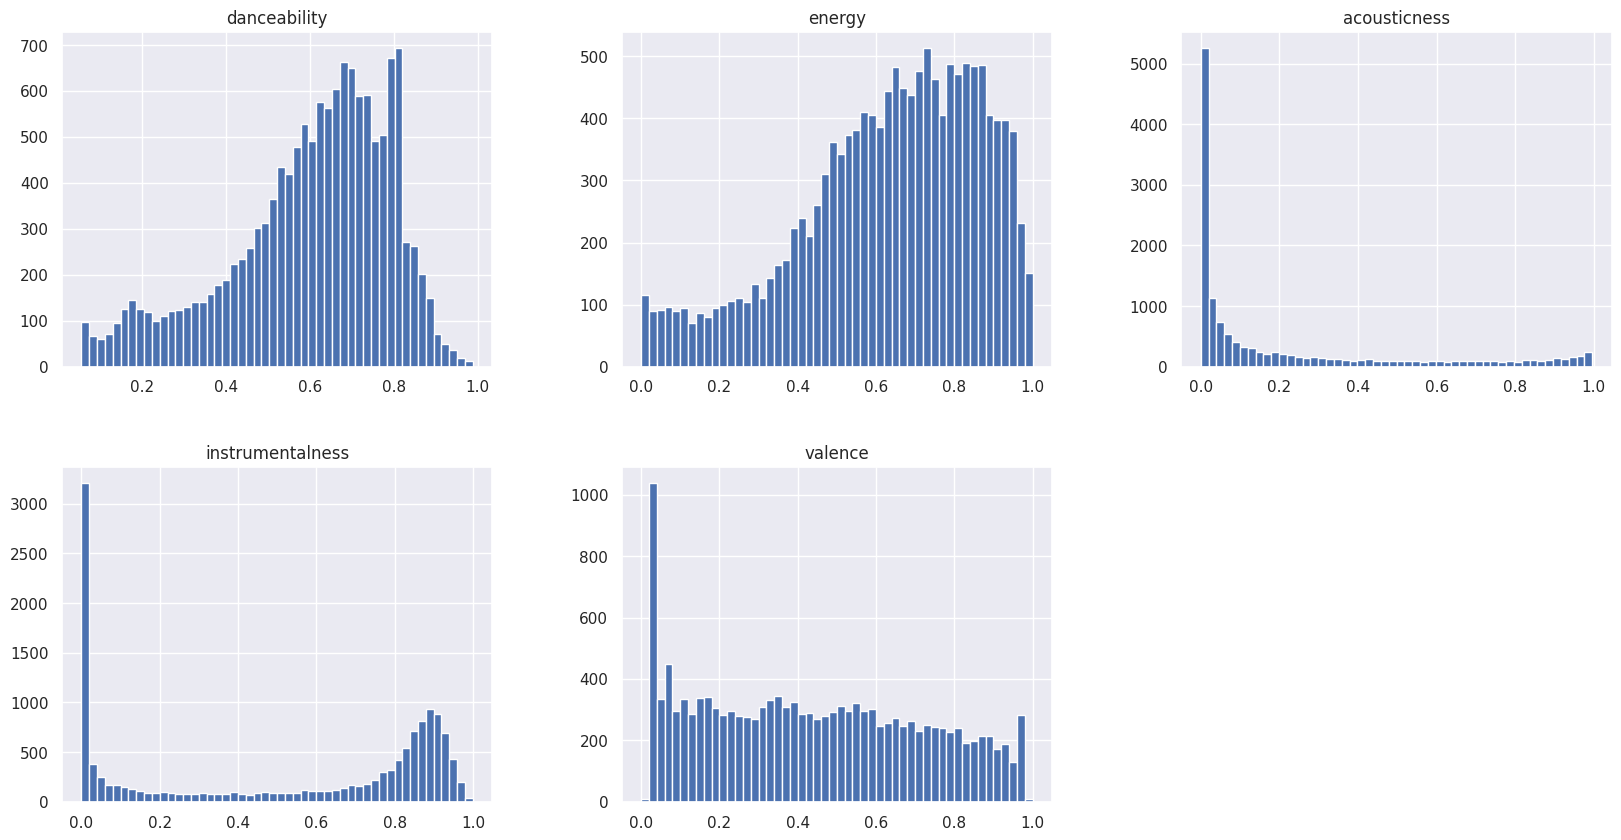

In [5]:
data[variables].hist(bins=50, figsize=(20,10), layout=(2,3))

# Normally distribute values

danceability


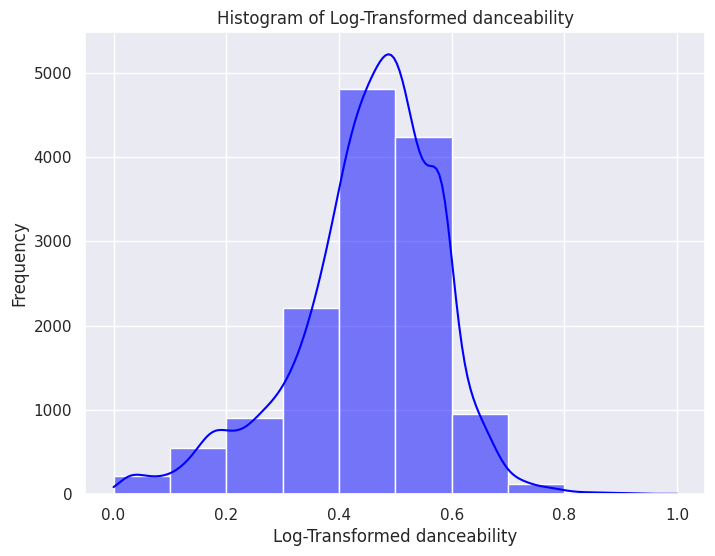

energy


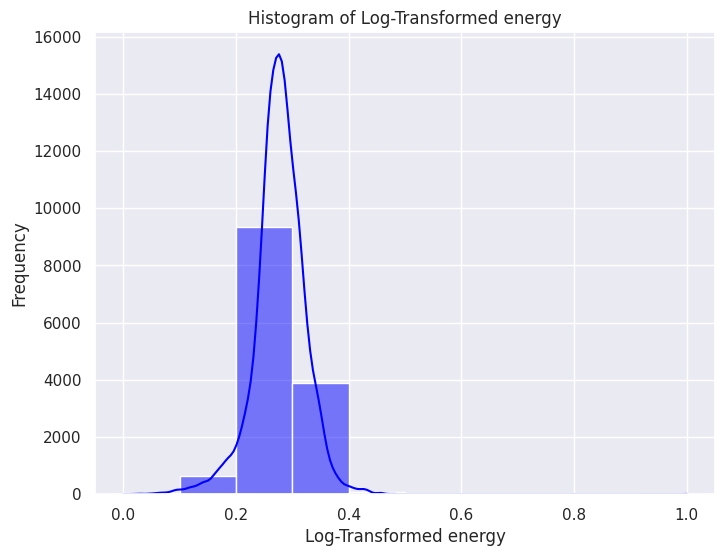

acousticness


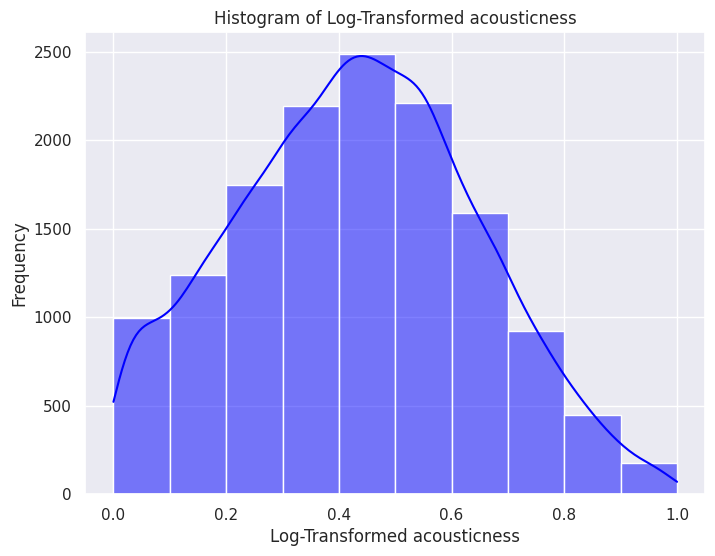

instrumentalness


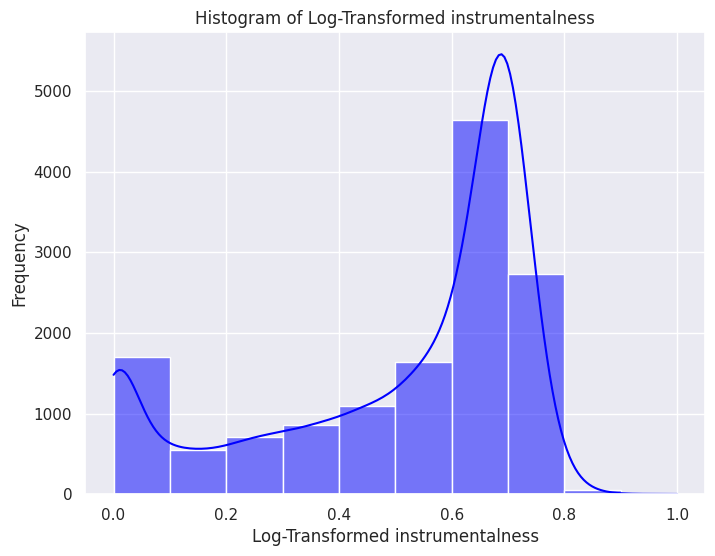

valence


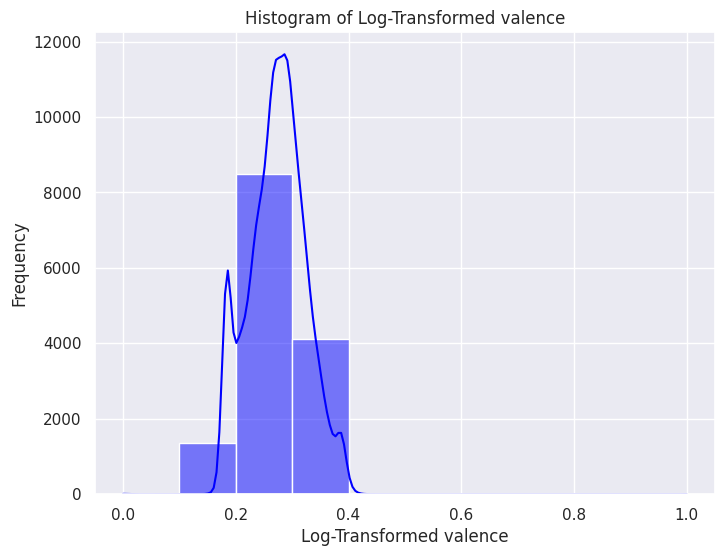

In [71]:
from sklearn.mixture import GaussianMixture


def normalize(feature: str, fn):
    data[f'{feature}_transformed'] = fn(data[feature])


def plot_histogram(series, feature):
    plt.figure(figsize=(8, 6))
    sns.histplot(series, kde=True, color='blue', bins=10)
    plt.title(f'Histogram of Log-Transformed {feature}')
    plt.xlabel(f'Log-Transformed {feature}')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


def log_transformation(series):
    small_constant = 0.01
    return np.log(series + small_constant)


def inverse_transformation(series):
    small_constant = 0.01
    return 1 / (series + small_constant)


def sigmoid_transformation(series):
    x = (series - 0.5) * 10
    return 1 / (1 + np.exp(-x))


def boxcox_transformation(series):
    transformed_data, lambda_val = stats.boxcox(series + 0.00001)
    return transformed_data


def gaussian_transformation(series):
    n_components = 2  # Number of Gaussian components
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    x = series.to_numpy().reshape(-1, 1)

    gmm.fit(x)
    probs = gmm.predict_proba(x)
    # Use probability as the target variable
    # You may need to reshape the array depending on your specific requirements
    prob_target_variable = probs[:, 0]  # You may choose the probability of one of the components
    return prob_target_variable


from sklearn.preprocessing import MinMaxScaler


def custom_transform(series):
    normal_data = np.log(0.0001 + series / (1 - series + 1e-10))
    normal_data = normal_data.to_numpy().reshape(-1, 1)
    
    scaler = MinMaxScaler()
    scaler.fit(normal_data)
    normalized_target = scaler.transform(normal_data)
    return normalized_target, scaler


scalers = {}
for v in variables:
    print(v)
    data[f'{v}_transformed'], scalers[v] = custom_transform(data[v])
    plot_histogram(data[f'{v}_transformed'], v)

In [82]:
# Restore original data

def inverse_custom_transform(series, feature):
    # Inverse transform to get back the normalized target variable data
    normal_data = scalers[feature].inverse_transform(series.to_numpy().reshape(-1,1))
    
    # Reverse the log transformation
    series = np.exp(normal_data) - 0.0001
    
    # Inverse of the normalization
    series = (series / (1 + series))
    
    return series



for v in variables:
    data[f"{v}_restored"] = inverse_custom_transform(data[f"{v}_transformed"], v)
    print(data[[v, f"{v}_restored"]].describe())

       danceability  danceability_restored
count  14008.000000           14008.000000
mean       0.599196               0.599196
std        0.192551               0.192551
min        0.055300               0.055300
25%        0.495750               0.495750
50%        0.637000               0.637000
75%        0.743250               0.743250
max        0.988000               0.988000
             energy  energy_restored
count  14008.000000     14008.000000
mean       0.631336         0.631336
std        0.233408         0.233408
min        0.000264         0.000264
25%        0.492000         0.492000
50%        0.666000         0.666000
75%        0.817000         0.817000
max        1.000000         1.000000
       acousticness  acousticness_restored
count  14008.000000           14008.000000
mean       0.220747               0.220747
std        0.302225               0.302225
min        0.000001               0.000001
25%        0.005610               0.005610
50%        0.055750   

In [83]:
for v in variables:
    data[f"{v}_original"] = data[v]
    data[v] = data[f"{v}_transformed"]


data.to_csv("/opt/app-root/src/music-recommendation/data/merged_normalized_1000_tag_probs_by_track.csv")

In [84]:
from joblib import dump

for v in variables:
    dump(scalers[v], f"/opt/app-root/src/music-recommendation/data/scaler_{v}.joblib")
